In [1]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import time
import collections
import community
import scipy.io
from networkx.algorithms.link_analysis import hits
from itertools import product
import itertools
import powerlaw as pl

#1.Creation of Graph
def createGraph(file):
    G=nx.Graph()

    mat = scipy.io.loadmat(file) #matlab file containing an adjacency matrix for the coactivation 
    #network that includes the weights of each edge and the coordinates of each node in the brain

    content = list(mat.values()) #content[3] weights of the edges; content[4] coordinates
    G = nx.from_numpy_matrix(content[3])

    return G

#2.Degree analysis
#Average Degree
def averageDegree(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    av_degree = (2*E)/N
    return av_degree

#Average Weighted Degree:
def averageWeightedDegree(G):
    N = G.number_of_nodes()
    weightedDegree = np.zeros(N)
    #we start by computing the weighted degree for each node (sum of weights of the edges linked to that node        
    for u, v, w in G.edges(data = 'weight'):
        #add weight to both nodes that share the edge
        weightedDegree[u] += w
        weightedDegree[v] += w
    av_weightedDegree = sum(weightedDegree)/N
    return [weightedDegree, av_weightedDegree]

#Degree Distribution   
#obtain plot of histogram, degree distribution and cumulative degree distribution
def degreeDistribution(G):
    #get sequence of the degrees of each node ordered 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence) #gives a list that as the degree and number of times it repeats
    degree, count = zip(*degreeCount.items()) #to obtain arguments separated 
    
    
    plt.figure() 
    plt.bar(degree, count, width=1) #plot histogram
    plt.xticks(np.arange(0, 190, 10))
    plt.title("Degree Histrogram")
    plt.ylabel("number of nodes")
    plt.xlabel("k")
    
    N = G.number_of_nodes()
    count = list(count) #convert to list
    # normalize count to obtain P(k)
    for i in range(len(count)):
        count[i] = count[i]/N
    
    plt.figure()
    plt.loglog(degree, count, 'o') #plot with log scaling on both axis
    plt.title("Degree Distribution with log-log scale")
    plt.ylabel("log₁₀ P(k)")
    plt.xlabel("log₁₀ k")

    count_cum = []
    for i in range(len(count)):
        count_cum += [sum(count[0:i+1])] #append each cum_sum to the list

    plt.figure()
    plt.loglog(degree, count_cum, 'o') #plot with log scaling on both axis
    plt.title("Cumulative Degree Distribution with log-log scale")
    plt.ylabel("log₁₀ Pcum(k)")
    plt.xlabel("log₁₀ k")
    
    degrees = G.degree() #get list with pairs (node, degree)
    valuesDeg = [d for n, d in degrees] #get list of degrees of each node
    #print("Degrees:", valuesDeg)
    
    #determine gamma for degree distribution
    parameters = pl.Fit(valuesDeg) #obtain parameters fitting to a power law distribution according to data
    gamma = parameters.alpha
    print("Gamma:", gamma)
    kmin = parameters.xmin
    kmax = parameters.xmax
    print("kmin:", kmin)
    print("kmax:", kmax)
    
    #determine number of nodes fitted by power-law
    numberNodes_aboveKmin = 0
    for i in range(len(valuesDeg)):
        if valuesDeg[i] > int(kmin):
            numberNodes_aboveKmin += 1
    print("Number of nodes with degree above kmin:", numberNodes_aboveKmin)

G = createGraph('Coactivation_matrix.mat')

av_degree = averageDegree(G)
print("The Average Degree of the network is: ", av_degree)

weightedDegree, av_w_degree = averageWeightedDegree(G)
print("The Average Weighted Degree of the network is: ", av_w_degree)

degreeDistribution(G)

The Average Degree of the network is:  58.38557993730407
The Average Weighted Degree of the network is:  3.2879135834493365


Calculating best minimal value for power law fit
/home/francisca/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Gamma: 4.029906348501841
kmin: 69.0
kmax: None
Number of nodes with degree above kmin: 198


In [13]:
#Getting average path lenght for every connected component
num_connected_components = 0
path_length_sum = 0
for g in nx.connected_component_subgraphs(G):
    shortest_path_g = nx.average_shortest_path_length(g)
    path_length_sum += shortest_path_g
    print("Average path lenght of connected component ",num_connected_components, ", having ", g.number_of_nodes(), " nodes: ", shortest_path_g)
    num_connected_components += 1
print("Total average path lenght: ", path_length_sum/num_connected_components)

#Finding average clustering coeficient
clustering_coefficient = nx.average_clustering(G) #average clustering coeficient
print("Clustering coefficient: ", clustering_coefficient)

Average path lenght of connected component  0 , having  638  nodes:  2.2148737961545844
Total average path lenght:  2.2148737961545844
Clustering coeficient:  0.3844533292242755


In [6]:
#computing clustering coefficient for a random network

E = G.number_of_edges()
N = G.number_of_nodes()
max_E = N*(N-1)*0.5
p = E/max_E #probability of connecting a random node with another

print(p)
#since the probability is quite small, we are going to have a sparse graph so it's better to use 
# fast_gnp_random_graph algorithm, provided by networkX, to generate a random graph instead of gnp_random_graph,
#because it is much faster when p is small and the expected number of edges is small (sparse)
# O(N+E) instead of O(N²)

random_G = nx.fast_gnp_random_graph(N,p)
random_clustering_coefficient = nx.average_clustering(random_G)
print("Clustering coefficient of random graph: ", random_clustering_coefficient)
#significantly lower than for our case!

0.09165711136154486
Clustering coefficient of random graph:  0.09197011358738011


In [9]:
#Getting clustering and degree for every node
degree_sequence = G.degree()
clustering_sequence = nx.clustering(G)
print(clustering_sequence)

{0: 0.28225806451612906, 1: 0.28923076923076924, 2: 0.38264580369843526, 3: 0.44894894894894893, 4: 0.22413793103448276, 5: 0.4537205081669691, 6: 0.4992163009404389, 7: 0.3860477314450564, 8: 0.21428571428571427, 9: 0.3007518796992481, 10: 0.336827393431167, 11: 0.2548217416715371, 12: 0.42177589852008457, 13: 0.19812925170068027, 14: 0.23673469387755103, 15: 0.24444444444444444, 16: 0.3914240755310779, 17: 0.2066326530612245, 18: 0.4213406292749658, 19: 0.4612640163098879, 20: 0.5882800608828006, 21: 0.24174174174174173, 22: 0.32522474881015334, 23: 0.29324699352451433, 24: 0.25161290322580643, 25: 0.22851153039832284, 26: 0.3473684210526316, 27: 0.43865546218487395, 28: 0.3817663817663818, 29: 0.3935897435897436, 30: 0.4735632183908046, 31: 0.4436701509872242, 32: 0.33978494623655914, 33: 0.5720720720720721, 34: 0.5517241379310345, 35: 0.5902597402597403, 36: 0.3460884353741497, 37: 0.4383869851159571, 38: 0.38001088336658806, 39: 0.4843987823439878, 40: 0.42424242424242425, 41: 0.3

In [15]:
#CENTRALITY
ev_centrality = nx.eigenvector_centrality_numpy(G)
print("Eigenvector centrality", ev_centrality)

#for k,v in sorted(ev_centrality.items(), key=lambda p:p[1], reverse=True):
    #print(k,v)

bn_centrality = nx.betweenness_centrality(G)
print("Betweeness centrality", bn_centrality)

#weighted Degree
print("Weighted Degree:", weightedDegree)

Eigenvector centrality {0: 0.003039522826410441, 1: 0.0018603433010364286, 2: 0.01970876547298143, 3: 0.0224559617610217, 4: 0.0016048708644181373, 5: 0.027149233214774113, 6: 0.053693718977570054, 7: 0.08525427762222917, 8: 0.005016898741366804, 9: 0.005543758515605927, 10: 0.018836927198819298, 11: 0.006844962918314064, 12: 0.02060070347685063, 13: 0.018243648819894497, 14: 0.004971821946616244, 15: 0.009673828158469303, 16: 0.08614744600281847, 17: 0.011433001962681405, 18: 0.04595620672542661, 19: 0.07797543131663717, 20: 0.050075583725129096, 21: 0.008238245608483288, 22: 0.0030003460985530534, 23: 0.0035093252478588595, 24: 0.0024113746296125483, 25: 0.009042241565770829, 26: 0.0029249171807121535, 27: 0.009189104314943373, 28: 0.004726515368580454, 29: 0.016307227887748237, 30: 0.006029910231489155, 31: 0.013498082425535022, 32: 0.0057413231089439055, 33: 0.0073770705605012464, 34: 0.005608713538135988, 35: 0.021221584924934613, 36: 0.022404444908095816, 37: 0.07341075694033748,

Betweeness centrality {0: 0.0010679709088381893, 1: 0.0007643194212274356, 2: 0.0009251182608225745, 3: 0.000731344353154541, 4: 0.001250244597506526, 5: 0.0024916961047958433, 6: 0.0010412327151938258, 7: 0.004704771052854631, 8: 0.0017601151320651382, 9: 0.0033844082514671277, 10: 0.0036471476708152422, 11: 0.0050952653194784835, 12: 0.0015335660692524337, 13: 0.003061221276946681, 14: 0.0025908183685500403, 15: 0.0018620139689022, 16: 0.00422111590638329, 17: 0.005031266507748306, 18: 0.002593110860454843, 19: 0.00211201007284138, 20: 0.0005459143981170759, 21: 0.0012852201292442927, 22: 0.003020281129832216, 23: 0.0026974953770785774, 24: 0.0016864747729162294, 25: 0.004428290787510182, 26: 0.0005108857513936195, 27: 0.0005960821696307883, 28: 0.0008962029248916711, 29: 0.0008694332746355801, 30: 0.00023360263771581125, 31: 0.0008873762774078129, 32: 0.0008644627943640734, 33: 0.00020386874659684214, 34: 0.00029923214991625126, 35: 0.0004493008244124218, 36: 0.0016005706972965468, 

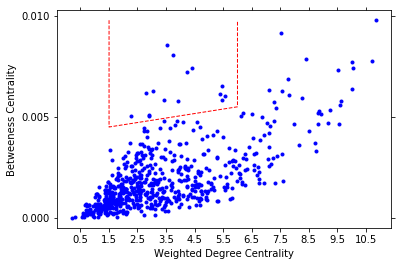

In [41]:
#x=list(ev_centrality.values())
y=list(bn_centrality.values())
x=list(weightedDegree)
#y=list(bn_centrality.values())

points = np.column_stack([x, y])
verts = np.array([[0.01, 0.01, 1.5, 1.5, ], [max(y)+0.005, 0.019, 0.030, max(y)+0.005]]).T
path = mpath.Path(verts)
points_inside = points[path.contains_points(points)]

plt.figure()
plt.autoscale(enable=True, axis='y', tight=False)
plt.autoscale(enable=True, axis='x', tight=False)
plt.xticks(np.arange(min(x)+0.3, max(x)+0.5, 1))
plt.yticks(np.arange(min(y), max(y)+0.005, 0.005))
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.ylabel("Betweeness Centrality")
#plt.xlabel("EigenVector Centrality")
plt.xlabel("Weighted Degree Centrality")
#plt.ylabel("Betweeness Centrality")


plt.plot(x, y, color='b', marker='o', linestyle="None", markersize=3)
#plt.savefig('dgVSbn.png')


plt.plot([1.5, 1.5, 6, 6, ], [max(y), 0.0045, 0.0055, max(y)], color='r', linewidth=1, linestyle='--')
plt.scatter(points_inside[:,0], points_inside[:,1], c='r', s=25)
plt.savefig('wdgVSbn.png')


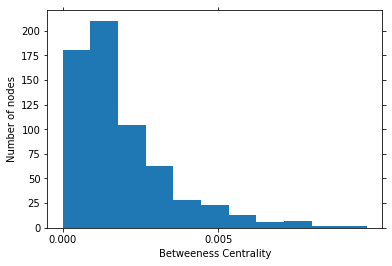

In [23]:
#Individual Histogram of Betweeness Centrality
x=list(bn_centrality.values())

plt.figure()
plt.hist(list(bn_centrality.values()), bins=11)
plt.xlabel("Betweeness Centrality")
plt.ylabel("Number of nodes")
plt.xticks(np.arange(min(x), max(x), 0.005))

plt.savefig("bn_hist.png")